In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [6]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')
# lsbg_cat['image_flag'] = np.ones(len(lsbg_cat), dtype=bool)
# lsbg_cat['psf_flag'] = np.ones(len(lsbg_cat), dtype=bool)
print('# of LSBGs:', len(lsbg_cat))
channels = 'griz'

# of LSBGs: 2000


In [245]:
lsbg = lsbg_cat[28] # 12 # 69

In [246]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


### Running scarlet spergel modeling for `./Cutout/mock_sample/mock_28`
    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    5 stars from Gaia are masked!
    Detected 243 objects
    5 stars from Gaia are masked!
    Detected 155 objects
    Detected 86 objects
  - Added Spergel profile with bbox = (4, 151, 151)
    Added constant sky background
    Total number of sources: 8
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 89 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 177 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 257 iterations! Try higher accuracy!
  - After 253 iterations, logL = 2532069.71
    Elapsed time for fitting: 149.64 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flu

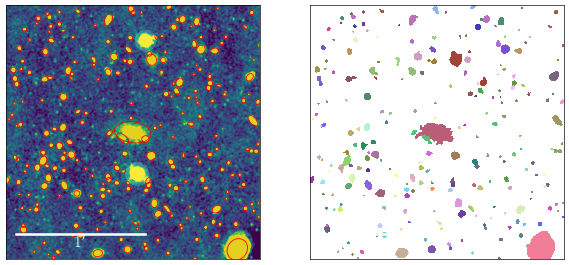

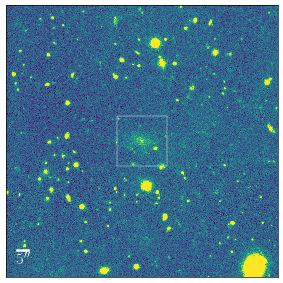

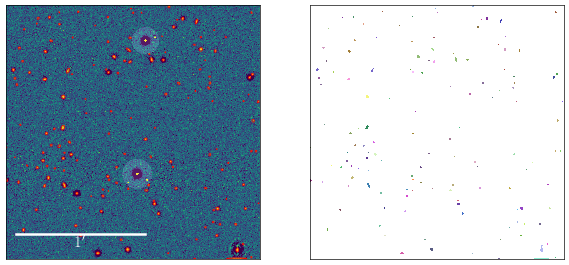

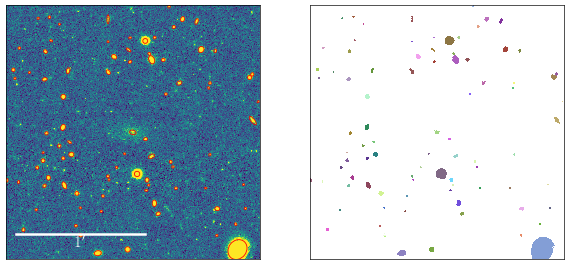

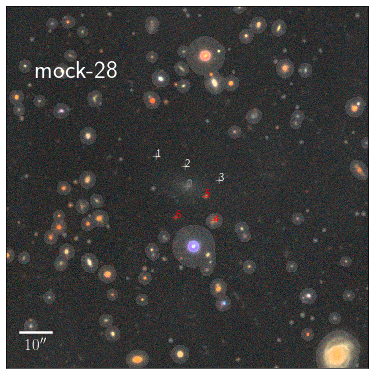

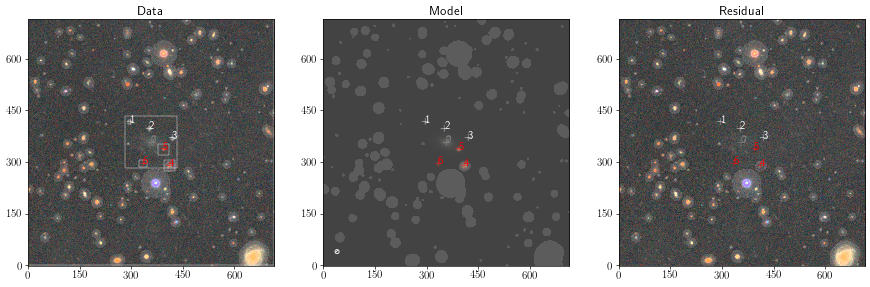

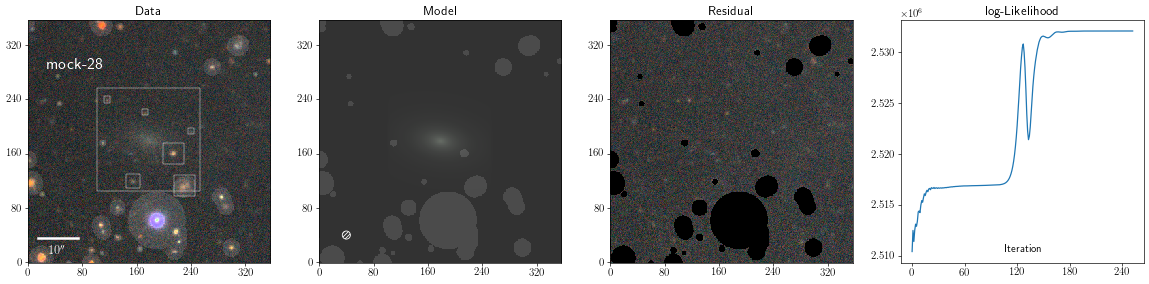

In [247]:
fitting_obs_tigress(env_dict, 
                    lsbg, 
                    name='viz-id',
                    method='spergel', 
                    min_grad=0.1,
#                     starlet_thresh=0.3,
#                     monotonic=True,
                    bkg=True,
#                     variance=0.015**2,
#                     scales=[0, 1, 2, 3, 4],
                    prefix='mock', 
                    model_dir='./Model/mock_sample/',
                    figure_dir='./Figure/mock_sample',
                    log_dir='./log/mock_sample',
                    show_figure=True)

In [259]:
def command(low, num):
    string = f'python deploy_mock.py --name mock_spgl --ncpu=8 '
    string += f'--starlet_thresh=0.3 --method=spergel --low={low} --high={low+num} '
    string += f'--monotonic=True --bkg=True --variance=0.000225 --min_grad=0.1 '
    string += f'--sigma=0.02 --scales="[0, 1, 2, 3, 4]"'
    print(string)
    return

In [260]:
for i in range(2, 5):
    command(i * 200, 200)

python deploy_mock.py --name mock_spgl --ncpu=8 --starlet_thresh=0.3 --method=spergel --low=400 --high=600 --monotonic=True --bkg=True --variance=0.000225 --min_grad=0.1 --sigma=0.02 --scales="[0, 1, 2, 3, 4]"
python deploy_mock.py --name mock_spgl --ncpu=8 --starlet_thresh=0.3 --method=spergel --low=600 --high=800 --monotonic=True --bkg=True --variance=0.000225 --min_grad=0.1 --sigma=0.02 --scales="[0, 1, 2, 3, 4]"
python deploy_mock.py --name mock_spgl --ncpu=8 --starlet_thresh=0.3 --method=spergel --low=800 --high=1000 --monotonic=True --bkg=True --variance=0.000225 --min_grad=0.1 --sigma=0.02 --scales="[0, 1, 2, 3, 4]"


In [222]:
# fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.2,
#                        monotonic=True, bkg=True,
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
#                        model_dir='./Model/mock_sample/',
#                        figure_dir='./Figure/mock_sample',
#                        log_dir='./log/mock_sample',
#                        prefix='mock', 
#                        index=lsbg['viz-id'], 
#                        show_figure=True)
# fitter.load_data(data, lsbg_coord)

fitter = ScarletFitter(method='spergel', tigress=True, bright=bright,
                       starlet_thresh=0.3, min_grad=-0.2, bkg=True,
#                        monotonic=True, 
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
                       model_dir='./Model/mock_sample/',
                       figure_dir='./Figure/mock_sample',
                       log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

#### Step-by-step

In [223]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    4 stars from Gaia are masked!


In [224]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 250 objects


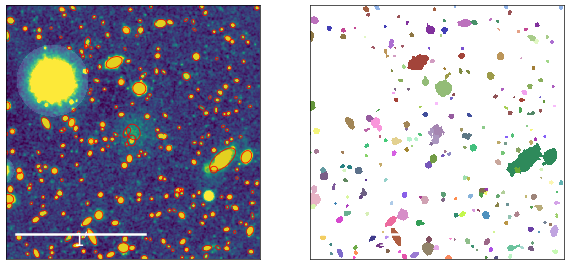

In [225]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont, conv_radius=2, lvl=4)

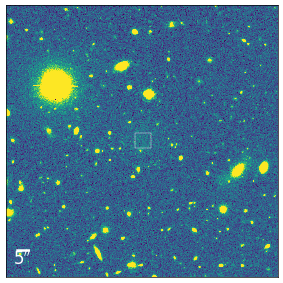

In [226]:
fitter._estimate_box(fitter.cen_obj)

In [227]:
fitter._mask_stars_outside_box()

    4 stars from Gaia are masked!


    Detected 194 objects


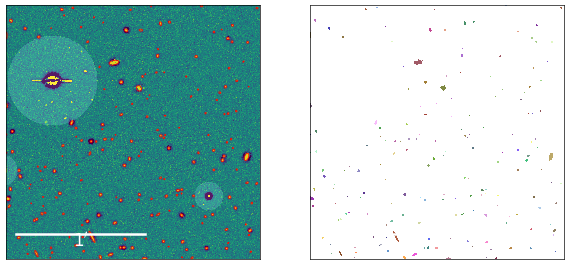

In [228]:
fitter._cpct_obj_detection()

In [229]:
from kuaizi.display import draw_circles

    Detected 109 objects


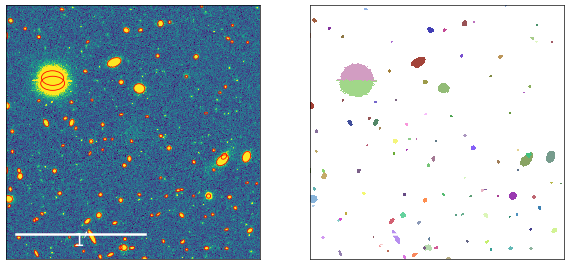

In [230]:
fitter._big_obj_detection()

In [231]:
fitter._merge_catalogs()

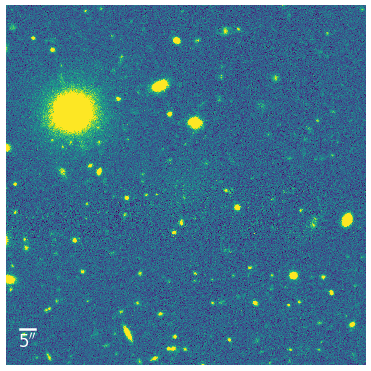

In [232]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [233]:
fitter._construct_obs_frames()

In [234]:
fitter._add_central_source(min_grad=-0.01, thresh=0.1)
fitter._add_other_sources(min_grad=0.1, thresh=0.1)

  - Added Spergel profile with bbox = (4, 151, 151)
    Added constant sky background
    Total number of sources: 2


In [24]:
from scarlet.source import SpergelSource, SingleExtendedSource
from kuaizi.measure import g1g2, flux_radius_array
src = fitter.cen_obj

In [25]:
new_source = scarlet.SingleExtendedSource(
    fitter.model_frame,
    (src['ra'], src['dec']),
    fitter.observation,
    satu_mask=fitter.data.masks,
    thresh=0.05,
    shifting=True,
    min_grad=0.1)
print(new_source.bbox)
sed, morph = new_source.get_models_of_children()
SED = np.array(new_source.spectrum * morph.sum())

<Box shape=(4, 81, 81), origin=(0, 317, 317)>


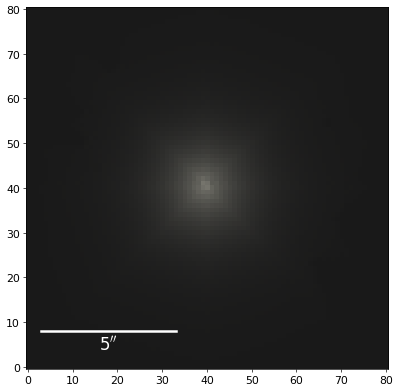

In [26]:
display_rgb(new_source.get_model());

In [27]:
new_source = scarlet.StarletSource(
    fitter.model_frame,
    (src['ra'], src['dec']),
    fitter.observation,
    thresh=0.1,
    starlet_thresh=1e-3,
    monotonic=False,
    variance=0.05**2,
    min_grad=0.01)
print(new_source.bbox)

<Box shape=(4, 161, 161), origin=(0, 277, 277)>


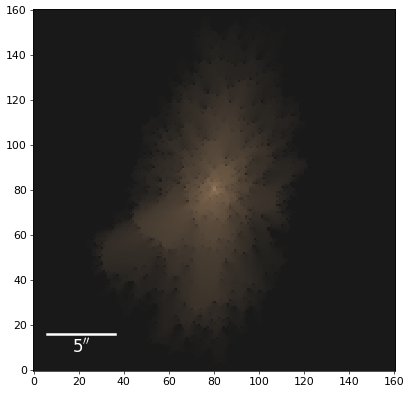

In [28]:
display_rgb(new_source.get_model());

In [29]:
_, morph = new_source.get_models_of_children()
# SED = np.array(new_source.spectrum * morph.sum())
g1, g2 = g1g2(np.array(morph))
rhalf = flux_radius_array(np.array(morph), 0.5)
print(rhalf)
nu = np.array([0.5])

david = scarlet.SpergelSource(
    fitter.model_frame,
    (src['ra'], src['dec']),
    nu, rhalf, np.array((g1[0], g2[0])),
    fitter.observation,
    SED=SED)

[26.75076834]


In [30]:
fitter._sources = [david]
# fitter._add_sources()
print(fitter._sources[0].bbox)
fitter.blend = scarlet.Blend(fitter._sources, fitter.observation)

<Box shape=(4, 269, 269), origin=(0, 223, 223)>


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

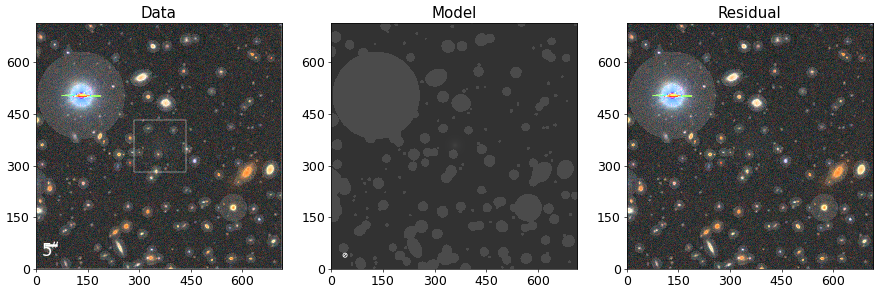

In [235]:
kz.display.display_scarlet_model(
    fitter.blend,
#     show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 85 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 165 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 245 iterations! Try higher accuracy!
  - After 245 iterations, logL = 2234603.87
    Elapsed time for fitting: 138.07 s


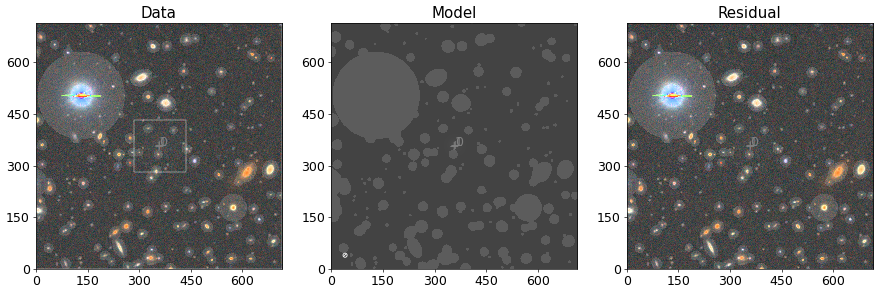

In [236]:
fitter._optimize()

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/mock_sample/mock-7-trained-model-spergel.df


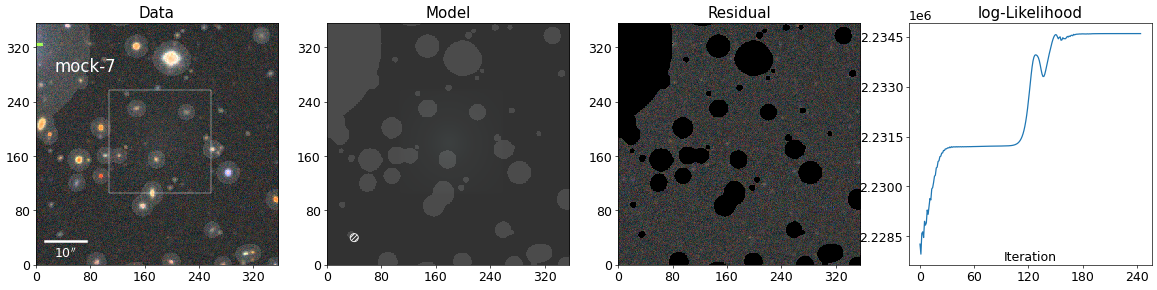

In [237]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
    fitter._display_results()
except:
    pass

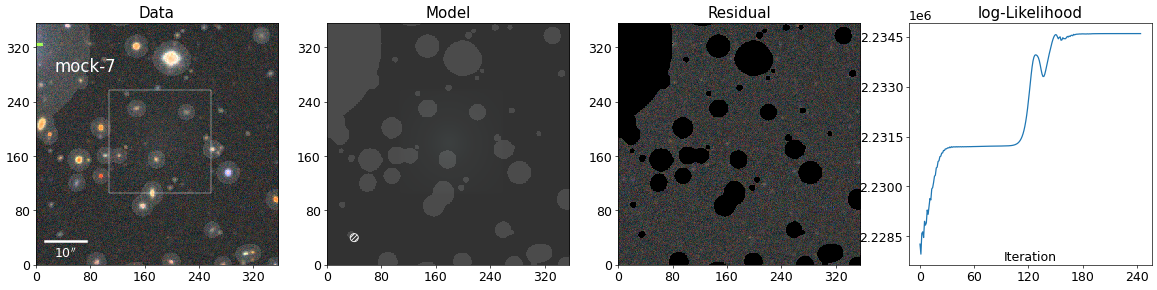

In [238]:
fitter._display_results()

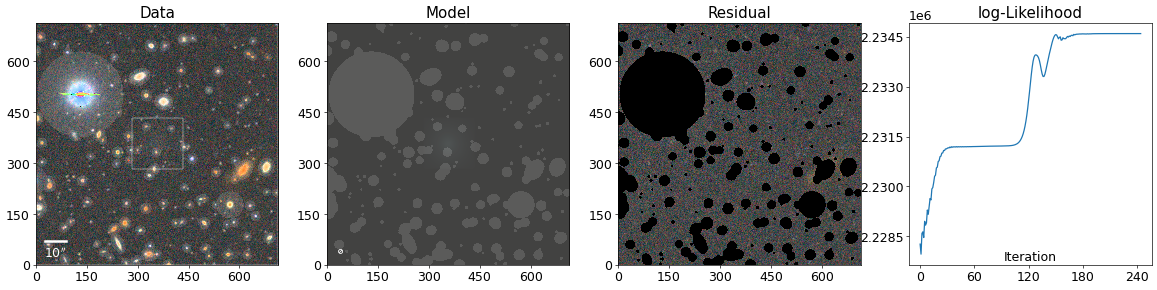

In [239]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
#         show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.7,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [240]:
from kuaizi.measure import cal_cnu
david = fitter.blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

[[9.78091718]]
mag: [[20.95255956 20.47541381 20.3080208  20.54341934]]
Sky: [30.39239143 29.73059861 28.67050248 28.82035989]


[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

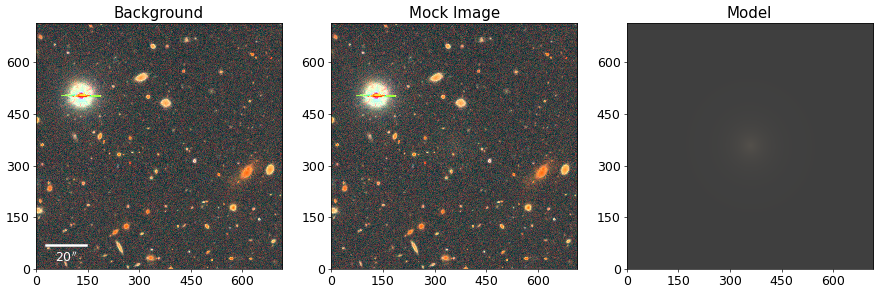

In [241]:
import pickle

with open(f'./Cutout/mock_sample/mock_{lsbg["viz-id"]}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [244]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.9633822325633931,
    'half_light_radius': 12.097237240417355},
   'shear_params': {'q': 0.956260928877007,
    'beta': coord.Angle(-1.2817051303891247, coord.radians)},
   'sed': array([0.5723978 , 0.83970861, 1.        , 1.16199369])}],
 'imag': 19.8831568836033,
 'flux_fraction': [1.0],
 'ra': 346.1801183805011,
 'dec': 0.9159681129547782,
 'gmag': 20.4889119964195,
 'rmag': 20.072835367354816,
 'zmag': 19.720147458149533}

In [100]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

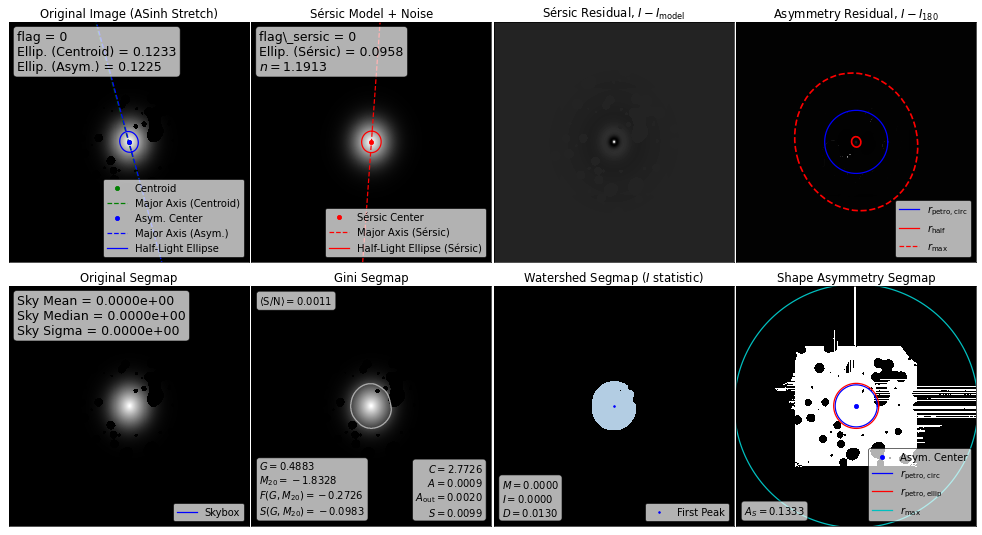

In [101]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [102]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([29.4934964 , 28.74595229, 28.74534842, 28.11704383])

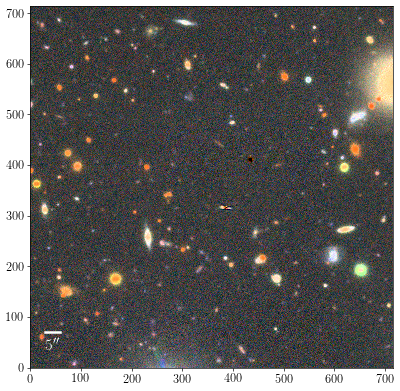

In [142]:
display_rgb(gal.mock.images - fitter.observation.render(fitter.blend.get_model()), stretch=0.8);

In [104]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

4.914961939897793
4.556496604388463


5.068036433903733

In [105]:
measurement['SB_eff_avg'], measurement['mag']

(array([25.790022, 25.45826 , 25.405367, 25.216639], dtype=float32),
 array([20.323706, 19.991943, 19.93905 , 19.75032 ], dtype=float32))

In [106]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.344858, 20.013096, 19.960203, 19.771473], dtype=float32)

In [107]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(20.420431085096865, 20.089120531929915, 19.987150741690147)

In [108]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.12251074353348768, 0.1277100516230144)

In [249]:
import dill
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

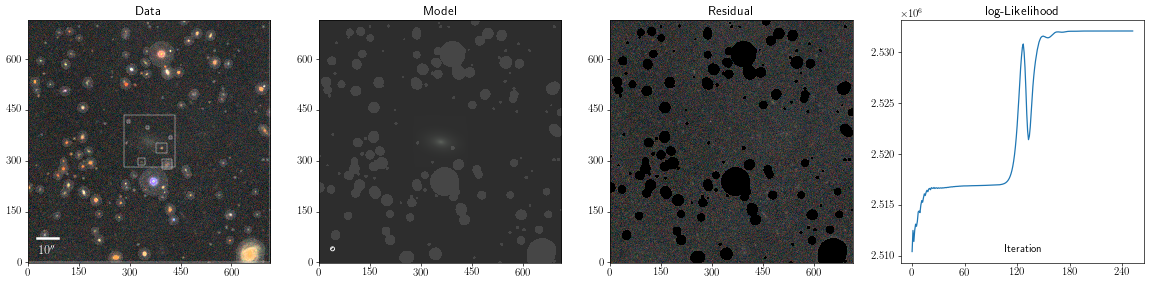

In [250]:
ind = 28
method = 'spergel'
# method = 'vanilla'
with open(f'./Model/mock_sample/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

In [251]:
from kuaizi.measure import cal_cnu
david = blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
-2.5 * np.log10(true_flux * sed) + 27.0

[[5.35024453]]


Parameter([[21.09256138, 20.52215181, 20.21650564, 20.24670457]])

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

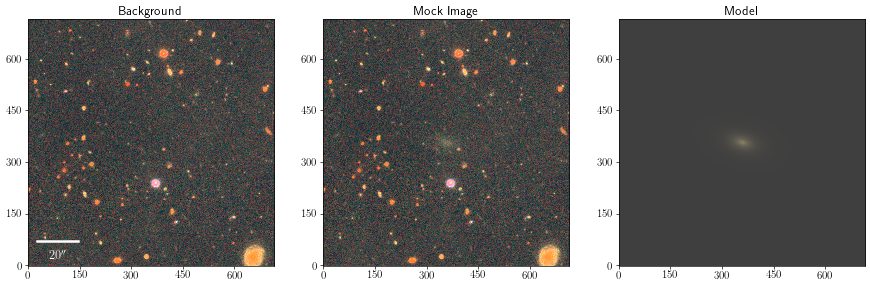

In [252]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display(stretch=0.8)

In [253]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 1.0951803789590369,
    'half_light_radius': 5.334890811775221},
   'shear_params': {'q': 0.5680019184235323,
    'beta': coord.Angle(-0.25005238755917447, coord.radians)},
   'sed': array([0.451382  , 0.78303453, 1.        , 1.02531584])}],
 'imag': 20.171148799404545,
 'flux_fraction': [1.0],
 'ra': 343.9186149118894,
 'dec': 1.5810709302754862,
 'gmag': 21.03478821285135,
 'rmag': 20.436696513145392,
 'zmag': 20.144004633656426}

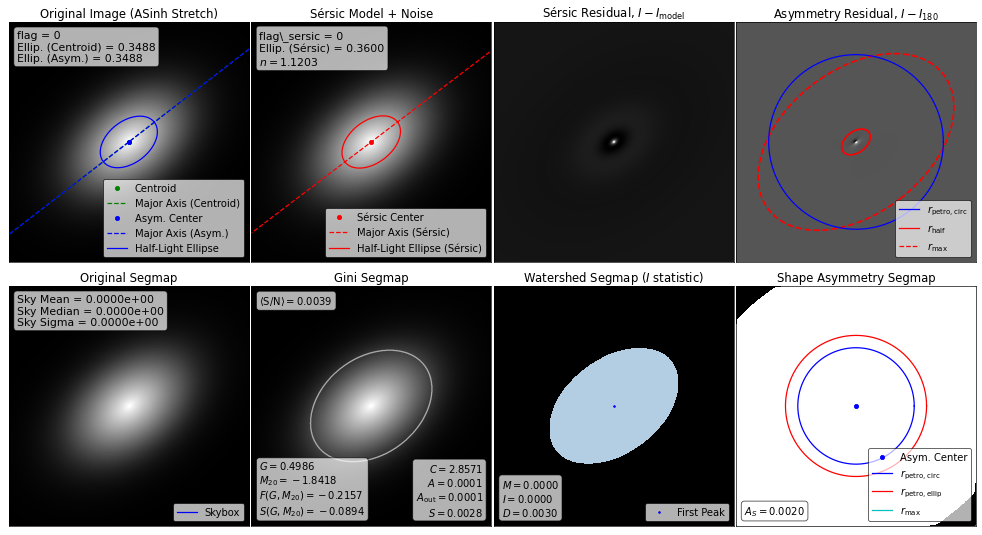

In [15]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 aggr_mask=mask.astype(bool),
                                 method='spergel',
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)